# Protein Dataset Analysis
Following [Brian Risk's](https://www.kaggle.com/code/devraai/bioinformatics-protein-dataset-analysis/notebook) kaggle guide, this notebook will perform protein database analysis on a set of 20,000 synthetic proteins.

In [2]:
# # unzip data
# from zipfile import ZipFile

# with ZipFile("../Data/archive.zip", "r") as zfile:
#     zfile.extractall("../Data")

In [3]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
# load dataset
test = pd.read_csv("../Data/proteinas_test.csv")
train = pd.read_csv("../Data/proteinas_train.csv")
# enriched = pd.read_csv("../Data/proteinas_20000_enriquecido.csv")

print(train.head())
# rename cols to english:
# new col names
col_names = [
    "protein_id",
    "sequence",
    "molecular_mass",
    "isoelectric_point",
    "hydrophobicity",
    "total_charge",
    "polar_proportion",
    "nonpolar_proportion",
    "sequence_length",
    "class"
]
# check if col name order is the same in train and test data
if all(test.columns==train.columns):
# rename cols
    train.columns = col_names
    test.columns = col_names
# verify new col names applied 
print(train.columns)
# verify col names in train and test datasets match 
print(test.columns==train.columns)

    ID_Proteína                                          Sequência  \
0  TRAIN_P00001  GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...   
1  TRAIN_P00002  LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...   
2  TRAIN_P00003  PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...   
3  TRAIN_P00004  GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...   
4  TRAIN_P00005  HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...   

   Massa_Molecular  Ponto_Isoelétrico  Hidrofobicidade  Carga_Total  \
0       20362.9468           4.866123         0.149425           -3   
1        9328.7909           6.298636         0.217105            0   
2       17616.3852           8.458977         0.192568            8   
3       35244.2968           8.448340         0.160473           21   
4       34557.9931           7.696306         0.140411           18   

   Proporção_Polar  Proporção_Apolar  Comprimento_Sequência      Classe  
0         0.241379          0.408046                    174  Estrutural  
1   

In [5]:
# rename class values to english
print(train['class'].unique())
# define new class keys 
class_mapping = {'Estrutural':'Structural','Receptora':'Receptor','Enzima':'Enzyme', 'Transporte':'Transport', 'Outras':'Other'}
# rename class values using if statement so that mapping never reruns (would delete all) 
if train['class'][0] in class_mapping.keys():
    train['class'] = train['class'].map(class_mapping)
if test['class'][0] in class_mapping.keys():
    test['class'] = test['class'].map(class_mapping)
# confirmation 
print(train['class'].unique(), test['class'].unique())
print(train.head())
class_order = train['class']

['Estrutural' 'Receptora' 'Enzima' 'Transporte' 'Outras']
['Structural' 'Receptor' 'Enzyme' 'Transport' 'Other'] ['Receptor' 'Enzyme' 'Structural' 'Other' 'Transport']
     protein_id                                           sequence  \
0  TRAIN_P00001  GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...   
1  TRAIN_P00002  LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...   
2  TRAIN_P00003  PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...   
3  TRAIN_P00004  GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...   
4  TRAIN_P00005  HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...   

   molecular_mass  isoelectric_point  hydrophobicity  total_charge  \
0      20362.9468           4.866123        0.149425            -3   
1       9328.7909           6.298636        0.217105             0   
2      17616.3852           8.458977        0.192568             8   
3      35244.2968           8.448340        0.160473            21   
4      34557.9931           7.696306        0.140411         

### Cleaning + Preprocessing

In [6]:
# check for missing data
print(train.isnull().sum())
print(test.isnull().sum())
# no missing data in any column bc synthetic data 

# convert class levels to numericals
train['class'] = train['class'].astype('category').cat.codes
test['class'] = test['class'].astype('category').cat.codes
# .astype('category') --> dtype pd.Categorical
# .cat = categorical accessor, ie to access the categories/levels 
# .codes = sets numeric codes for the levels, -1 for missing values; goes with the inherent ALPHABETICAL?? order seen in the data, but can set explicitly
classes = dict(enumerate(sorted(class_mapping.values())))


protein_id             0
sequence               0
molecular_mass         0
isoelectric_point      0
hydrophobicity         0
total_charge           0
polar_proportion       0
nonpolar_proportion    0
sequence_length        0
class                  0
dtype: int64
protein_id             0
sequence               0
molecular_mass         0
isoelectric_point      0
hydrophobicity         0
total_charge           0
polar_proportion       0
nonpolar_proportion    0
sequence_length        0
class                  0
dtype: int64


## Exploratory Data Analysis

In [7]:
print(train.shape,'\n', train.dtypes)
# .describe() default only shows numeric cols 
# --> (include= ) can specify dtypes to show, but here it's only the ID cols that are non numeric
train.describe()

(16000, 10) 
 protein_id              object
sequence                object
molecular_mass         float64
isoelectric_point      float64
hydrophobicity         float64
total_charge             int64
polar_proportion       float64
nonpolar_proportion    float64
sequence_length          int64
class                     int8
dtype: object


,molecular_mass,isoelectric_point,hydrophobicity,total_charge,polar_proportion,nonpolar_proportion,sequence_length,class
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,20708.209250,7.274537,0.149983,8.729938,0.200260,0.399930,174.033688,2.001813
std,8678.439780,1.448253,0.027485,7.537891,0.033875,0.042192,72.920304,1.419880
min,5463.212900,4.050028,0.014563,-20.000000,0.049180,0.200000,50.000000,0.000000
25%,13165.853975,6.048970,0.132911,3.000000,0.178899,0.373376,111.000000,1.000000
50%,20597.677000,7.196834,0.150000,8.000000,0.200000,0.400000,173.000000,2.000000
75%,28193.961625,8.586190,0.167364,13.000000,0.221239,0.426573,237.000000,3.000000
max,37588.751700,11.711987,0.284314,47.000000,0.380282,0.607843,300.000000,4.000000


In [9]:
# classes = dict(enumerate(sorted(class_mapping.values())))
print(classes.values())


dict_values(['Enzyme', 'Other', 'Receptor', 'Structural', 'Transport'])


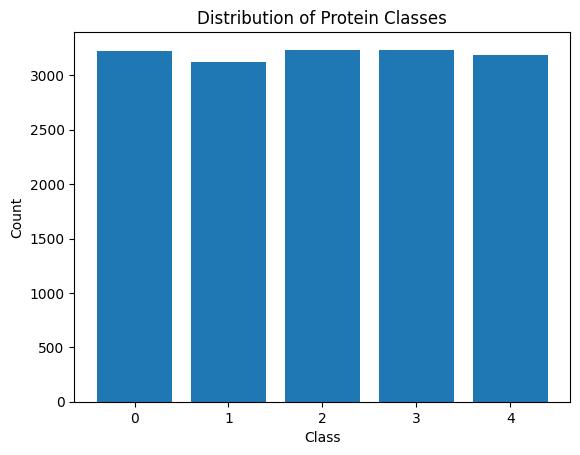

In [41]:
plt.bar(train["class"].unique(), train["class"].value_counts())
plt.title("Distribution of Protein Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


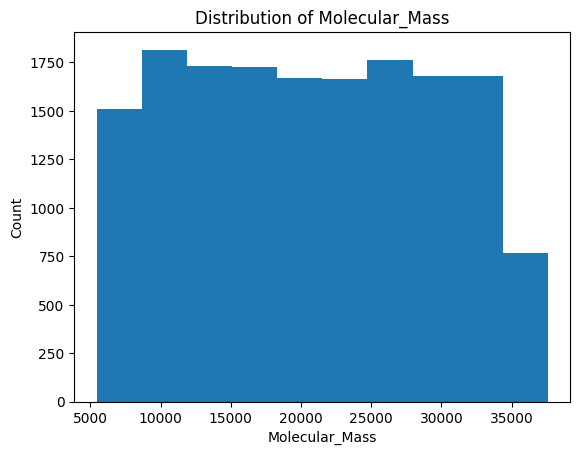

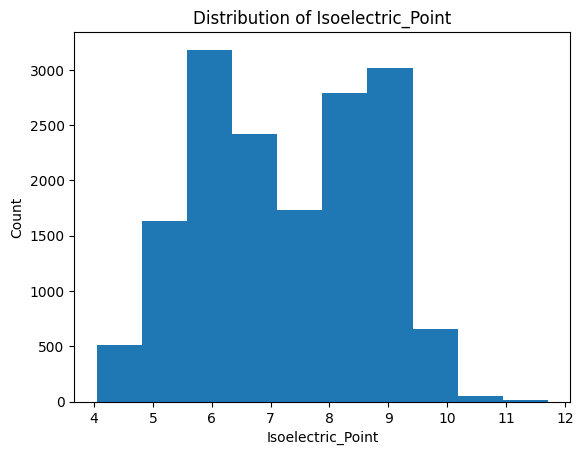

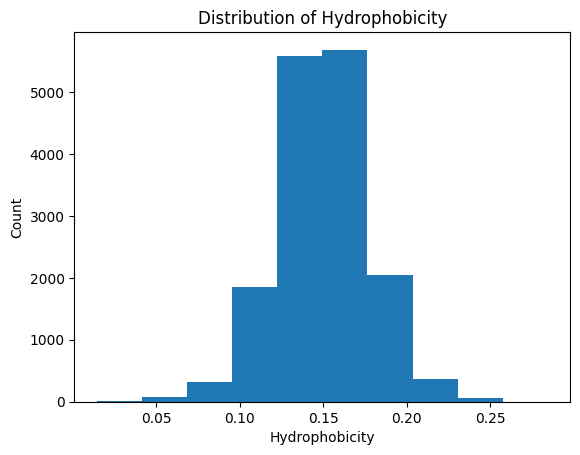

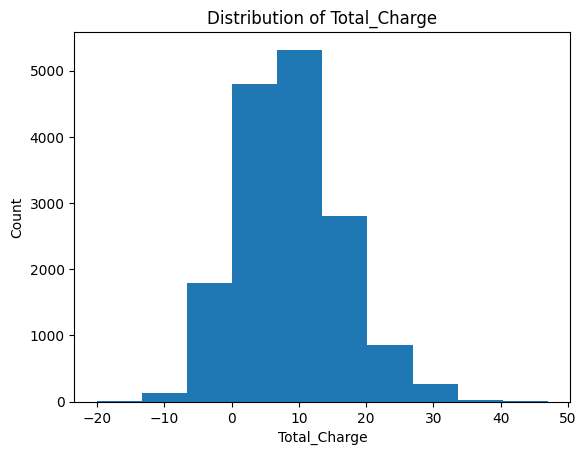

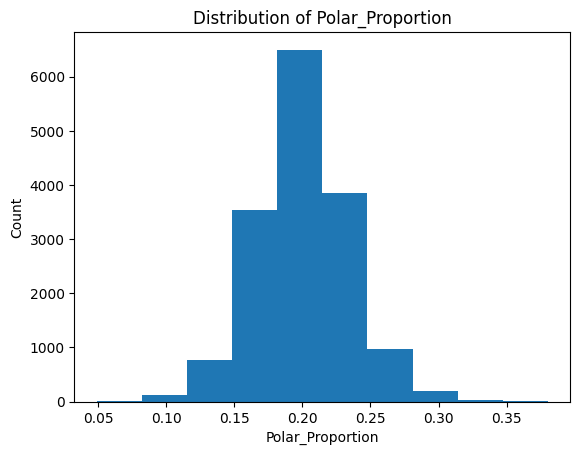

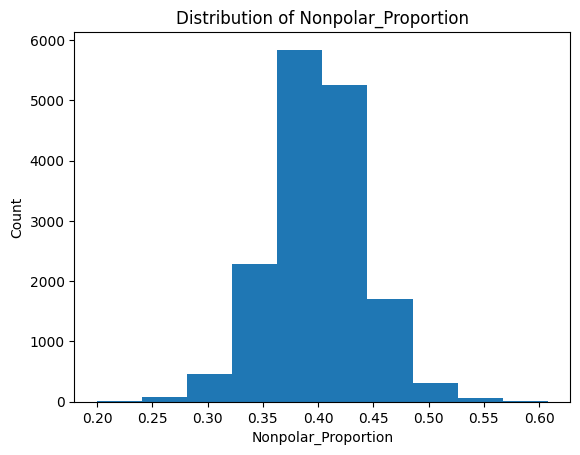

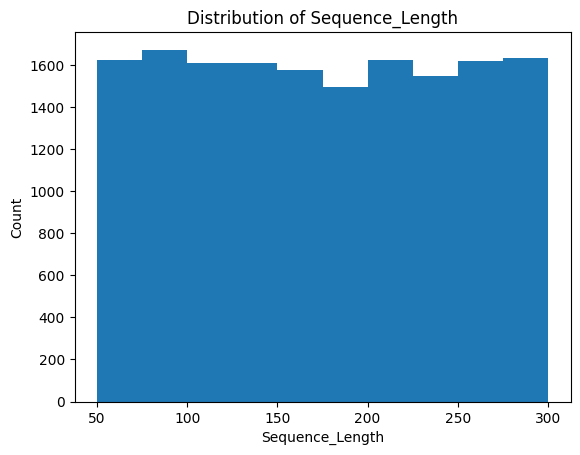

In [35]:
num_cols = train.select_dtypes(include=[np.number]).columns.to_list()
num_cols.remove("class")

for i in num_cols:
    i_df = train[i]
    plt.hist(i_df)
    plt.title(f"Distribution of {i.title()}")
    plt.xlabel(f"{i.title()}")
    plt.ylabel("Count")
    plt.show()



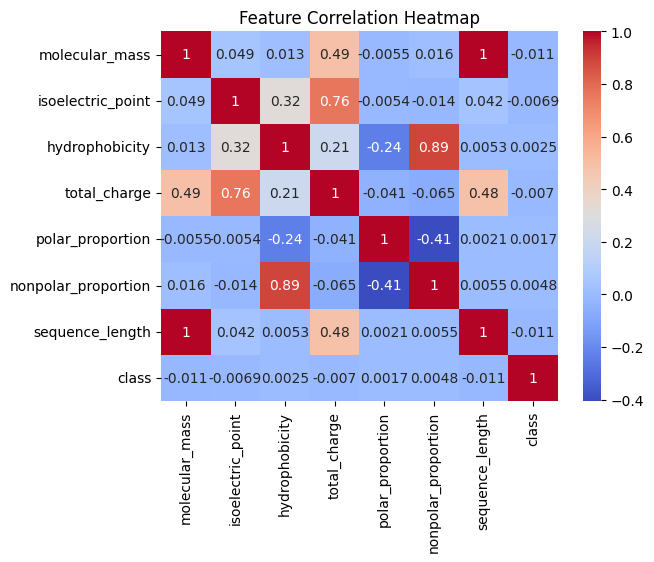

In [71]:
# heatmap bw numeric features
# build correlation matrix
# df[numeric_cols].corr() 
numeric_df = train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
# put corr matrix into .heatmap()
# sns.heatmap(correlation_matrix, annot=True)  annot= show correlation values
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Build Classification Model

In [72]:
# target feature split
# train
y_train = train['class']
# drop target and identifier cols (protein id, protein sequence) 
X_train = train.drop(columns=['class', 'protein_id', 'sequence'])
# test
y_test = test['class']
X_test = test.drop(columns=['class', 'protein_id', 'sequence'])

# build model
# INSTANTIATE, FIT, PREDICT
randf = RandomForestClassifier(random_state=17)
randf.fit(X_train, y_train)
y_pred = randf.predict(X_test)

Random Forest Accuracy: 0.20


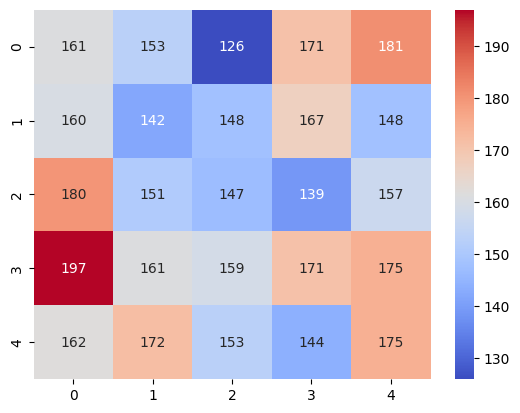

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy:.2f}')

# test v pred confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# (...fmt='format') format for annotations
    # '.1f' == 1 decimal place correlation
    # 'd' == count data
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.show()

### Results
The ML model performs poorly, with a 20% accuracy of labeling protein classes. This can be expected based on fairly uniform distribition patterns of and lack of correlations between features, as seen in the distribution plots and Feature Correlation Heatmap. \
The data's synthetic nature may result in a lack of unique or meaningful characterisation of protein classes. 